# WQF7009 Explainable AI: Assignment 3 - XAI on Chest X-Ray Pneumonia Classification

## 1. Setup & Import

In [1]:
!uv build ../
!uv pip install ../dist/wqf7009_a3-0.1.0-py3-none-any.whl

Building source distribution (uv build backend)...
Successfully built d:\jherng\Workspace\university\masters\courses\year2526_sem1\wqf7009_explainable_artificial_intelligence\assignment3\wqf7009-a3\dist\wqf7009_a3-0.1.0.tar.gz
Successfully built d:\jherng\Workspace\university\masters\courses\year2526_sem1\wqf7009_explainable_artificial_intelligence\assignment3\wqf7009-a3\dist\wqf7009_a3-0.1.0-py3-none-any.whl
Using Python 3.12.12 environment at: D:\jherng\Workspace\university\masters\courses\year2526_sem1\wqf7009_explainable_artificial_intelligence\assignment3\wqf7009-a3\.venv
Resolved 47 packages in 1.13s
Prepared 1 package in 14ms
Uninstalled 1 package in 11ms
Installed 1 package in 10ms
 ~ wqf7009-a3==0.1.0 (from file:///D:/jherng/Workspace/university/masters/courses/year2526_sem1/wqf7009_explainable_artificial_intelligence/assignment3/wqf7009-a3/dist/wqf7009_a3-0.1.0-py3-none-any.whl)


In [2]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchsummary
from pytorch_grad_cam import GradCAM
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from wqf7009_a3.dataset import (
    IMAGENET_MEAN,
    IMAGENET_STD,
    IMG_SIZE,
    get_dataloader,
    transform,
)
from wqf7009_a3.infer import predict
from wqf7009_a3.loss import get_weighted_bce_loss
from wqf7009_a3.models import get_model
from wqf7009_a3.trainer import evaluate
from wqf7009_a3.utils import set_seed
from wqf7009_a3.xai import RISE, visualize_gradcam, visualize_rise


In [3]:
PROJECT_ROOT = Path(os.getcwd()).parent
DATA_DIR = PROJECT_ROOT / "data" / "chest_xray"
MODELS_DIR = PROJECT_ROOT / "models"  # Dir for model dumps
FIG_DIR = PROJECT_ROOT / "docs" / "figures"  # Dir for figures
LOG_DIR = PROJECT_ROOT / "runs"  # Dir for TensorBoard logs

TRAIN_DIR = DATA_DIR / "train"
VAL_DIR = DATA_DIR / "val"
TEST_DIR = DATA_DIR / "test"

CLASSES = ["NORMAL", "PNEUMONIA"]
BATCH_SIZE = 32  # Increase until out-of-memory errors occur
NUM_WORKERS = 4  # Number of subprocesses for data loading
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

set_seed(42)
LOG_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)


In [4]:
print(f"Project root directory: {PROJECT_ROOT.as_posix()}")
print(f"Training data directory: {TRAIN_DIR.relative_to(PROJECT_ROOT).as_posix()}")
print(f"Validation data directory: {VAL_DIR.relative_to(PROJECT_ROOT).as_posix()}")
print(f"Test data directory: {TEST_DIR.relative_to(PROJECT_ROOT).as_posix()}")
print(f"Using device: {DEVICE}")

Project root directory: d:/jherng/Workspace/university/masters/courses/year2526_sem1/wqf7009_explainable_artificial_intelligence/assignment3/wqf7009-a3
Training data directory: data/chest_xray/train
Validation data directory: data/chest_xray/val
Test data directory: data/chest_xray/test
Using device: cuda


## 2. `Task 1` - Data Preparation & Pre-processing (5%)

### 2.1. Explore the Dataset

Based on the plotted class distribution, we can observe that the dataset is imbalanced, with a higher number of 'NORMAL' cases (1341) compared to 'PNEUMONIA' cases (3875). This imbalance may affect the performance of machine learning models, as they might be biased towards the majority class.

To address this, we'll use ***class weighting*** during model training to give more importance to the minority class ('NORMAL').

Dataset Statistics:
--------------------------------------------------
NORMAL      : Train=1341, Val=  8, Test=234
PNEUMONIA   : Train=3875, Val=  8, Test=390


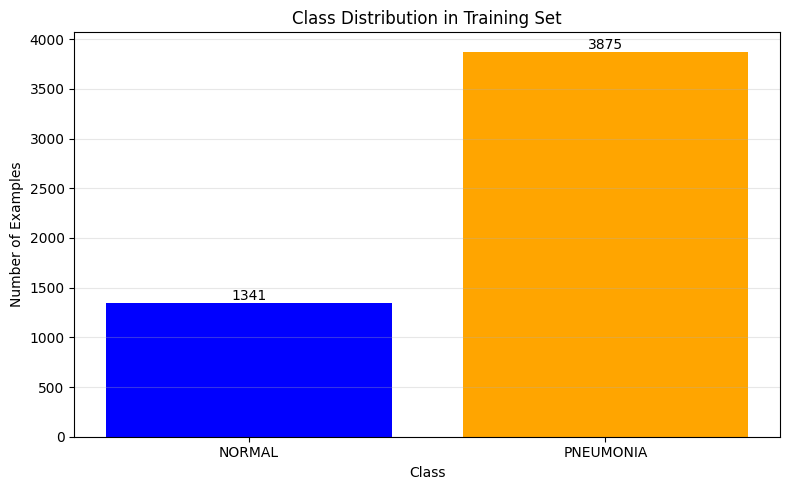

In [5]:
# Helper function to count images in each class
def count_images_by_class(data_dir, class_name):
    """Count number of images in a class directory."""
    return len(list((data_dir / class_name).glob("*.jpeg")))

# List number of examples in each class
print("Dataset Statistics:")
print("-" * 50)
for class_dir in CLASSES:
    train_count = count_images_by_class(TRAIN_DIR, class_dir)
    val_count = count_images_by_class(VAL_DIR, class_dir)
    test_count = count_images_by_class(TEST_DIR, class_dir)
    print(f"{class_dir:12s}: Train={train_count:4d}, Val={val_count:3d}, Test={test_count:3d}")

# Plot the class distribution
train_counts = [count_images_by_class(TRAIN_DIR, cls) for cls in CLASSES]
plt.figure(figsize=(8, 5))
plt.bar(CLASSES, train_counts, color=["blue", "orange"])
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Number of Examples")
plt.grid(axis="y", alpha=0.3)
for i, count in enumerate(train_counts):
    plt.text(i, count, str(count), ha="center", va="bottom")
plt.tight_layout()
plt.savefig(FIG_DIR / "class_distribution.png", dpi=150)
plt.show()

### 2.2. Data Pre-processing

In [6]:
# Data preprocessing pipeline
print("Transform pipeline:")
print(transform)

Transform pipeline:
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [7]:
train_loader = get_dataloader(
    data_dir=DATA_DIR,
    split="train",
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=DEVICE.type == "cuda",
    transform=transform,
)
val_loader = get_dataloader(
    data_dir=DATA_DIR,
    split="val",
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=DEVICE.type == "cuda",
    transform=transform,
)
test_loader = get_dataloader(
    data_dir=DATA_DIR,
    split="test",
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=DEVICE.type == "cuda",
    transform=transform,
)

Dataset Information:
--------------------------------------------------
Training examples:   5216
Validation examples:   16
Test examples:        624
Classes: ['NORMAL', 'PNEUMONIA']
Class to index: {'NORMAL': 0, 'PNEUMONIA': 1}


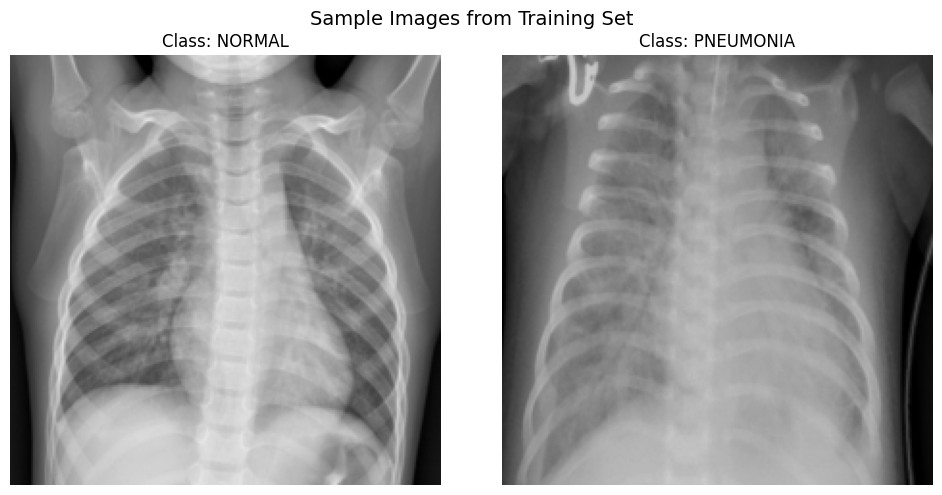

In [8]:
# Helper function to denormalize image for visualization
def denormalize_image(tensor_img):
    """Convert normalized tensor image back to displayable format."""
    img = tensor_img.permute(1, 2, 0).numpy()
    img = img * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)
    return np.clip(img, 0, 1)

# Sanity checks
print("Dataset Information:")
print("-" * 50)
print(f"Training examples:   {len(train_loader.dataset):4d}")
print(f"Validation examples: {len(val_loader.dataset):4d}")
print(f"Test examples:       {len(test_loader.dataset):4d}")
print(f"Classes: {train_loader.dataset.classes}")
print(f"Class to index: {train_loader.dataset.class_to_idx}")

# Plot sample images from each class
normal_idx = np.where(np.array(train_loader.dataset.targets) == 0)[0][0]
pneumonia_idx = np.where(np.array(train_loader.dataset.targets) == 1)[0][0]
normal_img, normal_label = train_loader.dataset[normal_idx]
pneumonia_img, pneumonia_label = train_loader.dataset[pneumonia_idx]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(denormalize_image(normal_img))
axs[0].set_title(f"Class: {train_loader.dataset.classes[normal_label]}")
axs[0].axis("off")
axs[1].imshow(denormalize_image(pneumonia_img))
axs[1].set_title(f"Class: {train_loader.dataset.classes[pneumonia_label]}")
axs[1].axis("off")
plt.suptitle("Sample Images from Training Set", fontsize=14)
plt.tight_layout()
plt.show()

# Verify class mapping
assert train_loader.dataset.class_to_idx == {"NORMAL": 0, "PNEUMONIA": 1}, (
    "Class to index mapping is incorrect. Expected {'NORMAL': 0, 'PNEUMONIA': 1}"
)

## 3. `Task 2` - Model Training, Comparison & Evaluation (5%)

### 3.1. Model Summary

In [9]:
# Initialize all models
models_config = {
    "simple_cnn": {"model_name": "simplecnn", "freeze_features": None},
    "resnet152_frozen": {"model_name": "resnet152", "freeze_features": True},
    "resnet152_unfrozen": {"model_name": "resnet152", "freeze_features": False},
    "vgg16_frozen": {"model_name": "vgg16", "freeze_features": True},
    "vgg16_unfrozen": {"model_name": "vgg16", "freeze_features": False},
}

models = {}
for name, config in models_config.items():
    kwargs = {"num_classes": 1}
    if config["freeze_features"] is not None:
        kwargs["freeze_features"] = config["freeze_features"]
    models[name] = get_model(model_name=config["model_name"], **kwargs).to(DEVICE)
    print(f"Initialized {name}")

# Keep individual variables for backward compatibility
simple_cnn = models["simple_cnn"]
resnet152_frozen = models["resnet152_frozen"]
resnet152_unfrozen = models["resnet152_unfrozen"]
vgg16_frozen = models["vgg16_frozen"]
vgg16_unfrozen = models["vgg16_unfrozen"]


Initialized simple_cnn
Initialized resnet152_frozen
Initialized resnet152_unfrozen
Initialized vgg16_frozen
Initialized vgg16_unfrozen


In [10]:
# Helper function to print model summary
def print_model_summary(model, model_name=None):
    """Print model architecture summary."""
    name = model_name or model._get_name()
    print(f"\n{'='*70}")
    print(f"Model: {name}")
    print(f"{'='*70}")
    torchsummary.summary(model.to(DEVICE), (3, IMG_SIZE, IMG_SIZE), device=str(DEVICE))

print_model_summary(simple_cnn, "SimpleCNN")


Model: SimpleCNN
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
              ReLU-5         [-1, 64, 112, 112]               0
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]          73,856
              ReLU-8          [-1, 128, 56, 56]               0
         MaxPool2d-9          [-1, 128, 28, 28]               0
AdaptiveAvgPool2d-10            [-1, 128, 7, 7]               0
          Flatten-11                 [-1, 6272]               0
           Linear-12                  [-1, 256]       1,605,888
             ReLU-13                  [-1, 256]               0
          Dropout-14 

In [11]:
print_model_summary(resnet152_frozen, "ResNet152 (frozen features)")
print_model_summary(resnet152_unfrozen, "ResNet152 (unfrozen features)")


Model: ResNet152 (frozen features)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
   

In [12]:
print_model_summary(vgg16_frozen, "VGG16 (frozen features)")
print_model_summary(vgg16_unfrozen, "VGG16 (unfrozen features)")


Model: VGG16 (frozen features)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
       

### 3.2. Model Training

In [13]:
!wqf7009-a3-train

usage: wqf7009-a3-train [-h] --model {simplecnn,vgg16,resnet152} [--freeze]
                        [--epochs EPOCHS] [--batch-size BATCH_SIZE]
                        [--data-dir DATA_DIR] [--lr LR]
                        [--num-workers NUM_WORKERS]
wqf7009-a3-train: error: the following arguments are required: --model


In [14]:
# Train the models with these commands:
# !wqf7009-a3-train --model=simplecnn --epochs=10 --batch-size=128 --data-dir=../data/chest_xray --lr=1e-4 --num-workers=4
# !wqf7009-a3-train --model=vgg16 --epochs=10 --batch-size=128 --data-dir=../data/chest_xray --lr=1e-4 --num-workers=4
# !wqf7009-a3-train --model=resnet152 --epochs=10 --batch-size=128 --data-dir=../data/chest_xray --lr=1e-4 --num-workers=4
# !wqf7009-a3-train --model=vgg16 --freeze --epochs=10 --batch-size=128 --data-dir=../data/chest_xray --lr=1e-4 --num-workers=4
# !wqf7009-a3-train --model=resnet152 --freeze --epochs=10 --batch-size=128 --data-dir=../data/chest_xray --lr=1e-4 --num-workers=4

I've trained the models on A100 GPUs somewhere else, we can load the trained models directly for evaluation in Task 3.

### 3.3. Model Evaluation

In [15]:
!wqf7009-a3-eval 

usage: wqf7009-a3-eval [-h] --model {simplecnn,vgg16,resnet152} --checkpoint
                       CHECKPOINT [--data-dir DATA_DIR]
                       [--batch-size BATCH_SIZE] [--split {train,val,test}]
wqf7009-a3-eval: error: the following arguments are required: --model, --checkpoint


#### SimpleCNN

In [16]:
!wqf7009-a3-eval --model=simplecnn \
    --checkpoint=../models/simplecnn_baseline_10ep_1767264997_best.pth \
    --data-dir=../data/chest_xray \
    --batch-size=32 \
    --split=test

Using device: cuda
⠋ Loading test dataset...

Loading weights from: simplecnn_baseline_10ep_1767264997_best.pth
Running inference...
┌─────────────────────────────────────────────────────────────────────────────┐
│ Evaluation Config: Model=simplecnn | Split=test                             │
└─────────────────────────────────────────────────────────────────────────────┘
   Detailed Evaluation Metrics   
┌──────────────────────┬────────┐
│               Metric │ Value  │
├──────────────────────┼────────┤
│             Accuracy │ 0.8093 │
│            Precision │ 0.7841 │
│ Recall (Sensitivity) │ 0.9590 │
│             F1 Score │ 0.8627 │
└──────────────────────┴────────┘
                  Confusion Matrix                   
┌────────────────────┬─────────────┬────────────────┐
│ Actual \ Predicted │ Pred NORMAL │ Pred PNEUMONIA │
├────────────────────┼─────────────┼────────────────┤
│      Actual NORMAL │     131     │      103       │
│   Actual PNEUMONIA │     16      │      374      


Evaluating: 100%|██████████| 20/20 [00:05<00:00,  3.96batch/s]


#### ResNet152 (Freeze Backbone)

In [17]:
!wqf7009-a3-eval --model=resnet152 \
    --checkpoint=../models/resnet152_frozen_10ep_1767266526_best.pth \
    --data-dir=../data/chest_xray \
    --batch-size=32 \
    --split=test

Using device: cuda
⠋ Loading test dataset...

Loading weights from: resnet152_frozen_10ep_1767266526_best.pth
Running inference...
┌─────────────────────────────────────────────────────────────────────────────┐
│ Evaluation Config: Model=resnet152 | Split=test                             │
└─────────────────────────────────────────────────────────────────────────────┘
   Detailed Evaluation Metrics   
┌──────────────────────┬────────┐
│               Metric │ Value  │
├──────────────────────┼────────┤
│             Accuracy │ 0.8125 │
│            Precision │ 0.8124 │
│ Recall (Sensitivity) │ 0.9103 │
│             F1 Score │ 0.8585 │
└──────────────────────┴────────┘
                  Confusion Matrix                   
┌────────────────────┬─────────────┬────────────────┐
│ Actual \ Predicted │ Pred NORMAL │ Pred PNEUMONIA │
├────────────────────┼─────────────┼────────────────┤
│      Actual NORMAL │     152     │       82       │
│   Actual PNEUMONIA │     35      │      355       │


Evaluating: 100%|██████████| 20/20 [00:05<00:00,  3.59batch/s]


#### ResNet152 (Fine-tune All Layers)

In [18]:
!wqf7009-a3-eval --model=resnet152 \
    --checkpoint=../models/resnet152_unfrozen_10ep_1767265644_best.pth \
    --data-dir=../data/chest_xray \
    --batch-size=32 \
    --split=test

Using device: cuda
⠋ Loading test dataset...

Loading weights from: resnet152_unfrozen_10ep_1767265644_best.pth
Running inference...
┌─────────────────────────────────────────────────────────────────────────────┐
│ Evaluation Config: Model=resnet152 | Split=test                             │
└─────────────────────────────────────────────────────────────────────────────┘
   Detailed Evaluation Metrics   
┌──────────────────────┬────────┐
│               Metric │ Value  │
├──────────────────────┼────────┤
│             Accuracy │ 0.8622 │
│            Precision │ 0.8248 │
│ Recall (Sensitivity) │ 0.9897 │
│             F1 Score │ 0.8998 │
└──────────────────────┴────────┘
                  Confusion Matrix                   
┌────────────────────┬─────────────┬────────────────┐
│ Actual \ Predicted │ Pred NORMAL │ Pred PNEUMONIA │
├────────────────────┼─────────────┼────────────────┤
│      Actual NORMAL │     152     │       82       │
│   Actual PNEUMONIA │      4      │      386      


Evaluating: 100%|██████████| 20/20 [00:05<00:00,  3.61batch/s]


#### VGG16 (Freeze Backbone)

In [19]:
!wqf7009-a3-eval --model=vgg16 \
    --checkpoint=../models/vgg16_frozen_10ep_1767266050_best.pth \
    --data-dir=../data/chest_xray \
    --batch-size=32 \
    --split=test

Using device: cuda
⠋ Loading test dataset...

Loading weights from: vgg16_frozen_10ep_1767266050_best.pth
Running inference...
┌─────────────────────────────────────────────────────────────────────────────┐
│ Evaluation Config: Model=vgg16 | Split=test                                 │
└─────────────────────────────────────────────────────────────────────────────┘
   Detailed Evaluation Metrics   
┌──────────────────────┬────────┐
│               Metric │ Value  │
├──────────────────────┼────────┤
│             Accuracy │ 0.8221 │
│            Precision │ 0.7807 │
│ Recall (Sensitivity) │ 0.9949 │
│             F1 Score │ 0.8749 │
└──────────────────────┴────────┘
                  Confusion Matrix                   
┌────────────────────┬─────────────┬────────────────┐
│ Actual \ Predicted │ Pred NORMAL │ Pred PNEUMONIA │
├────────────────────┼─────────────┼────────────────┤
│      Actual NORMAL │     125     │      109       │
│   Actual PNEUMONIA │      2      │      388       │
└──


Evaluating: 100%|██████████| 20/20 [00:05<00:00,  3.53batch/s]


#### VGG16 (Fine-tune All Layers)

In [20]:
!wqf7009-a3-eval --model=vgg16 \
    --checkpoint=../models/vgg16_unfrozen_10ep_1767265306_best.pth \
    --data-dir=../data/chest_xray \
    --batch-size=32 \
    --split=test

Using device: cuda
⠋ Loading test dataset...

Loading weights from: vgg16_unfrozen_10ep_1767265306_best.pth
Running inference...
┌─────────────────────────────────────────────────────────────────────────────┐
│ Evaluation Config: Model=vgg16 | Split=test                                 │
└─────────────────────────────────────────────────────────────────────────────┘
   Detailed Evaluation Metrics   
┌──────────────────────┬────────┐
│               Metric │ Value  │
├──────────────────────┼────────┤
│             Accuracy │ 0.8317 │
│            Precision │ 0.7890 │
│ Recall (Sensitivity) │ 0.9974 │
│             F1 Score │ 0.8811 │
└──────────────────────┴────────┘
                  Confusion Matrix                   
┌────────────────────┬─────────────┬────────────────┐
│ Actual \ Predicted │ Pred NORMAL │ Pred PNEUMONIA │
├────────────────────┼─────────────┼────────────────┤
│      Actual NORMAL │     130     │      104       │
│   Actual PNEUMONIA │      1      │      389       │
└


Evaluating: 100%|██████████| 20/20 [00:05<00:00,  3.54batch/s]


### 3.4. Model Comparison

First load all the trained weights into the respective models.

In [21]:
# Model checkpoint paths
checkpoints = {
    "simple_cnn": "simplecnn_baseline_10ep_1767264997_best.pth",
    "resnet152_frozen": "resnet152_frozen_10ep_1767266526_best.pth",
    "resnet152_unfrozen": "resnet152_unfrozen_10ep_1767265644_best.pth",
    "vgg16_frozen": "vgg16_frozen_10ep_1767266050_best.pth",
    "vgg16_unfrozen": "vgg16_unfrozen_10ep_1767265306_best.pth",
}

# Load trained model weights
print("Loading trained model weights...")
for name, checkpoint_file in checkpoints.items():
    checkpoint_path = MODELS_DIR / checkpoint_file
    if checkpoint_path.exists():
        models[name].load_state_dict(torch.load(checkpoint_path, map_location=DEVICE))
        print(f"Loaded {name} from {checkpoint_file}")
    else:
        print(f"Warning: {checkpoint_file} not found")

Loading trained model weights...
Loaded simple_cnn from simplecnn_baseline_10ep_1767264997_best.pth
Loaded resnet152_frozen from resnet152_frozen_10ep_1767266526_best.pth
Loaded resnet152_unfrozen from resnet152_unfrozen_10ep_1767265644_best.pth
Loaded vgg16_frozen from vgg16_frozen_10ep_1767266050_best.pth
Loaded vgg16_unfrozen from vgg16_unfrozen_10ep_1767265306_best.pth


In [22]:
# Setup loss function with class weighting
criterion = get_weighted_bce_loss(train_loader.dataset).to(DEVICE)
pos_weight = criterion.pos_weight.cpu().numpy()[0]
print(f"Loss function: {criterion}")
print(f"Positive class weight: {pos_weight:.4f} (for class 'PNEUMONIA')")
print()

# Evaluate all models on test set
print("Evaluating models on test set...")
print("-" * 50)
model_names_display = {
    "simple_cnn": "SimpleCNN",
    "resnet152_frozen": "ResNet152 (frozen)",
    "resnet152_unfrozen": "ResNet152 (unfrozen)",
    "vgg16_frozen": "VGG16 (frozen)",
    "vgg16_unfrozen": "VGG16 (unfrozen)",
}

results = {}
for name, display_name in model_names_display.items():
    print(f"Evaluating {display_name}...", end=" ")
    results[display_name] = evaluate(models[name], test_loader, criterion, DEVICE)
    print(f"(F1: {results[display_name][2]:.4f})")

Loss function: BCEWithLogitsLoss()
Positive class weight: 0.3461 (for class 'PNEUMONIA')

Evaluating models on test set...
--------------------------------------------------
Evaluating SimpleCNN... 

Evaluating :   0%|          | 0/20 [00:07<?, ?it/s]

(F1: 0.8627)
Evaluating ResNet152 (frozen)... 

Evaluating :   0%|          | 0/20 [00:27<?, ?it/s]

(F1: 0.8585)
Evaluating ResNet152 (unfrozen)... 

Evaluating :   0%|          | 0/20 [00:07<?, ?it/s]

(F1: 0.8998)
Evaluating VGG16 (frozen)... 

Evaluating :   0%|          | 0/20 [00:07<?, ?it/s]

(F1: 0.8749)
Evaluating VGG16 (unfrozen)... 

Evaluating :   0%|          | 0/20 [00:07<?, ?it/s]

(F1: 0.8811)


In [23]:
# Display results in a formatted table
print("\nModel Performance Summary:")
print("=" * 70)
results_df = pd.DataFrame(results, index=["Loss", "Accuracy", "F1 Score"]).T
results_df.round(4)


Model Performance Summary:


Loss  Accuracy  F1 Score
SimpleCNN             0.4575    0.8093    0.8627
ResNet152 (frozen)    0.3216    0.8125    0.8585
ResNet152 (unfrozen)  0.5864    0.8622    0.8998
VGG16 (frozen)        0.5849    0.8221    0.8749
VGG16 (unfrozen)      2.0633    0.8317    0.8811

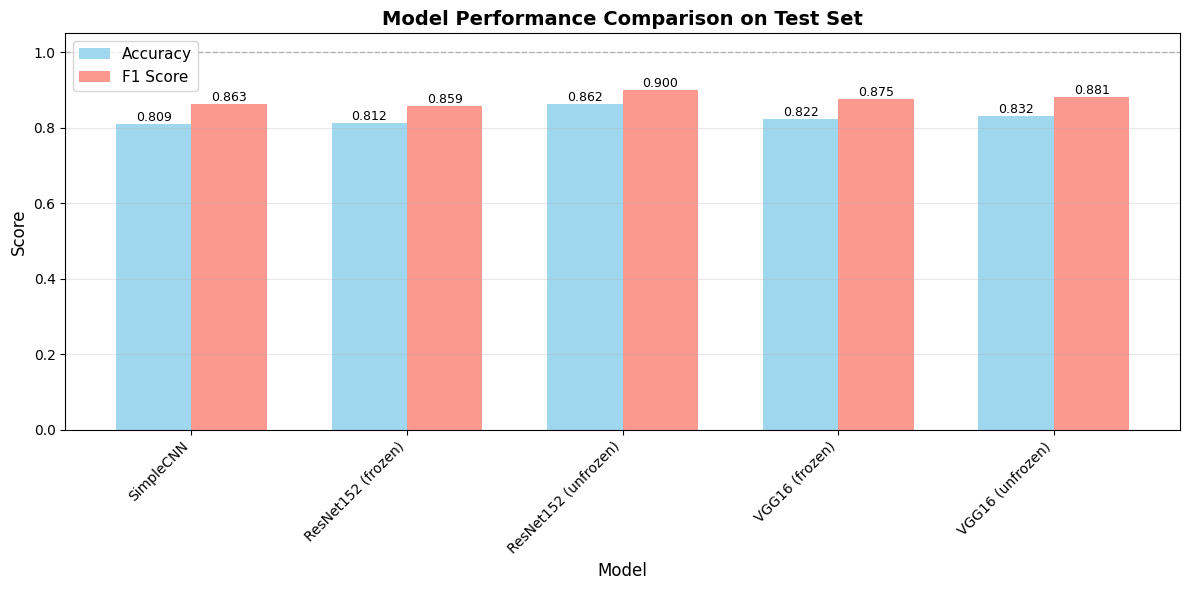

In [24]:
# Create comparison dataframe
df = pd.DataFrame(results, index=["Loss", "Accuracy", "F1 Score"]).T
df = df.drop(columns=["Loss"])

# Plot comparison of Accuracy and F1 Score
width = 0.35
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(df))
bars1 = ax.bar(x - width/2, df["Accuracy"], width, label="Accuracy", color="skyblue", alpha=0.8)
bars2 = ax.bar(x + width/2, df["F1 Score"], width, label="F1 Score", color="salmon", alpha=0.8)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

ax.axhline(y=1.0, color="gray", linestyle="--", linewidth=1, alpha=0.5)
ax.set_title("Model Performance Comparison on Test Set", fontsize=14, fontweight="bold")
ax.set_xlabel("Model", fontsize=12)
ax.set_ylabel("Score", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(df.index, rotation=45, ha="right")
ax.legend(fontsize=11)
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / "model_performance.png", dpi=150, bbox_inches="tight")
plt.show()

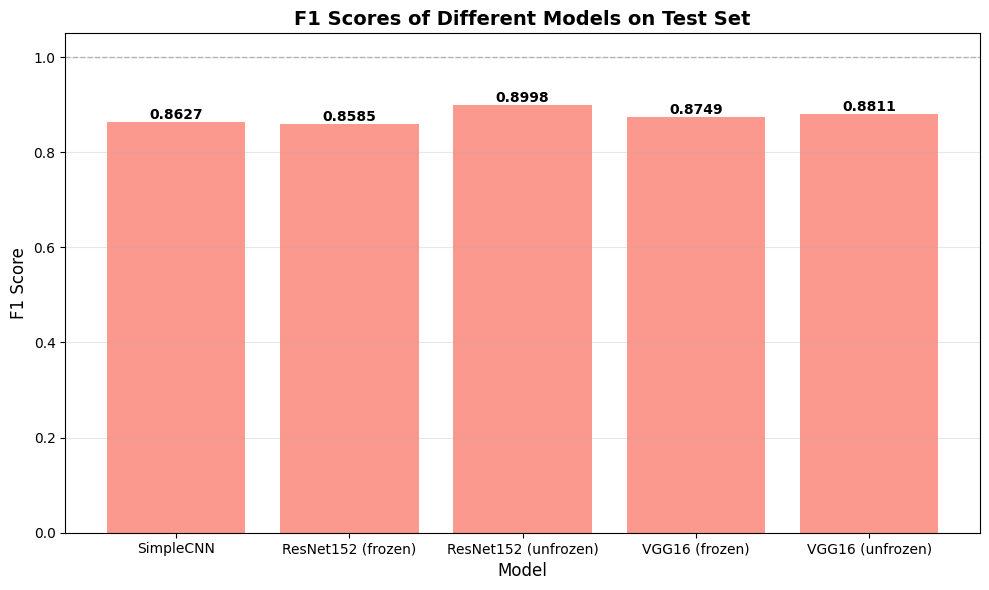

In [25]:
# Plot F1 scores comparison
f1_scores = df["F1 Score"].values
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(df.index, f1_scores, color="salmon", alpha=0.8, linewidth=1.5)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight="bold")

ax.axhline(y=1.0, color="gray", linestyle="--", linewidth=1, alpha=0.5)
ax.set_title("F1 Scores of Different Models on Test Set", fontsize=14, fontweight="bold")
ax.set_xlabel("Model", fontsize=12)
ax.set_ylabel("F1 Score", fontsize=12)
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / "f1_scores.png", dpi=150, bbox_inches="tight")
plt.show()

## 4. XAI Method 1 - Grad-CAM

In [26]:
# Find a batch with a good mix of pneumonia examples for visualization
print("Searching for a batch with pneumonia examples...")
images = None
labels = None
target_pneumonia_count = BATCH_SIZE // 2  # At least half the batch

for i, (batch_images, batch_labels) in enumerate(test_loader):
    pneumonia_count = (batch_labels.numpy() == 1).sum()
    print(f"  Batch {i}: {pneumonia_count} pneumonia examples")
    if pneumonia_count >= target_pneumonia_count:
        images = batch_images
        labels = batch_labels
        break

if images is None:
    print("Warning: No suitable batch found, using first batch")
    images, labels = next(iter(test_loader))

images = images.to(DEVICE)
labels = labels.numpy()
print(f"\n-> Selected batch with {len(labels)} examples ({labels.sum()} pneumonia cases)")


Searching for a batch with pneumonia examples...
  Batch 0: 0 pneumonia examples
  Batch 1: 0 pneumonia examples
  Batch 2: 0 pneumonia examples
  Batch 3: 0 pneumonia examples
  Batch 4: 0 pneumonia examples
  Batch 5: 0 pneumonia examples
  Batch 6: 0 pneumonia examples
  Batch 7: 22 pneumonia examples

-> Selected batch with 32 examples (22 pneumonia cases)


In [27]:
# Get predictions from the best performing model (ResNet152 unfrozen)
preds, probs = predict(images, model=resnet152_unfrozen)
preds, probs = preds.cpu().numpy(), probs.cpu().numpy()

# Calculate batch metrics
print("Batch Performance Metrics:")
print("-" * 50)
print(f"Accuracy:  {accuracy_score(labels, preds):.4f}")
print(f"F1 Score:  {f1_score(labels, preds):.4f}")
print(f"Precision: {precision_score(labels, preds):.4f}")
print(f"Recall:    {recall_score(labels, preds):.4f}")
print()

# Create dataframe with predictions sorted by confidence
df = pd.DataFrame({
    "labels": labels,
    "preds": preds,
    "probs": probs,
    "correct": (labels == preds).astype(int)
})
df = df.sort_values("probs", ascending=False)

print("Predictions sorted by confidence:")
df

Batch Performance Metrics:
--------------------------------------------------
Accuracy:  0.8750
F1 Score:  0.9167
Precision: 0.8462
Recall:    1.0000

Predictions sorted by confidence:


labels  preds     probs  correct
22       1      1  0.999979        1
23       1      1  0.999906        1
15       1      1  0.999904        1
13       1      1  0.999867        1
31       1      1  0.999847        1
25       1      1  0.999807        1
11       1      1  0.999789        1
28       1      1  0.999756        1
14       1      1  0.999717        1
26       1      1  0.999688        1
12       1      1  0.999668        1
16       1      1  0.999653        1
18       1      1  0.999649        1
29       1      1  0.999464        1
21       1      1  0.999420        1
27       1      1  0.999293        1
17       1      1  0.999273        1
20       1      1  0.999096        1
24       1      1  0.998902        1
19       1      1  0.998727        1
6        0      1  0.998645        0
4        0      1  0.998531        0
10       1      1  0.998155        1
2        0      1  0.997262        0
30       1      1  0.995750        1
7        0      1  0.991810        0
9        0      0  0.336039        1
3        0      0  0.120561        1
8        0      0  0.070298        1
1        0      0  0.008140        1
5        0      0  0.005114        1
0        0      0  0.000004        1

In [28]:
# Select examples for visualization: top 3 most confident and bottom 3 least confident
top_conf_inds = df.head(3).index.tolist()  # Top 3 most confident predictions
bot_conf_inds = df.tail(3).index.tolist()[
    ::-1
]  # Bottom 3 least confident (reversed for display)
all_conf_inds = top_conf_inds + bot_conf_inds

print(f"Selected {len(all_conf_inds)} examples for Grad-CAM visualization:")
print(f"  - Top 3 most confident: indices {top_conf_inds}")
print(f"  - Bottom 3 least confident: indices {bot_conf_inds}")
print("\nDetails:")
for idx in all_conf_inds:
    row = df.loc[idx]
    status = "->" if row["correct"] else "x"
    print(
        f"  {status} Index {idx}: Label={row['labels']}, Pred={row['preds']}, "
        f"Prob={row['probs']:.4f}"
    )

Selected 6 examples for Grad-CAM visualization:
  - Top 3 most confident: indices [22, 23, 15]
  - Bottom 3 least confident: indices [0, 5, 1]

Details:
  -> Index 22: Label=1.0, Pred=1.0, Prob=1.0000
  -> Index 23: Label=1.0, Pred=1.0, Prob=0.9999
  -> Index 15: Label=1.0, Pred=1.0, Prob=0.9999
  -> Index 0: Label=0.0, Pred=0.0, Prob=0.0000
  -> Index 5: Label=0.0, Pred=0.0, Prob=0.0051
  -> Index 1: Label=0.0, Pred=0.0, Prob=0.0081


### 4.1. `Task 3` - Implementation (5%)

In [29]:
# Initialize Grad-CAM for ResNet152
# Target the last layer of the final ResNet block (layer4) for feature visualization
target_layer = resnet152_unfrozen.model.layer4[-1]
cam = GradCAM(model=resnet152_unfrozen, target_layers=[target_layer])



Generating Grad-CAM visualizations for 6 examples...
----------------------------------------------------------------------
[1/6] Processing example 22: Label=1.0, Pred=1.0, Prob=1.0000


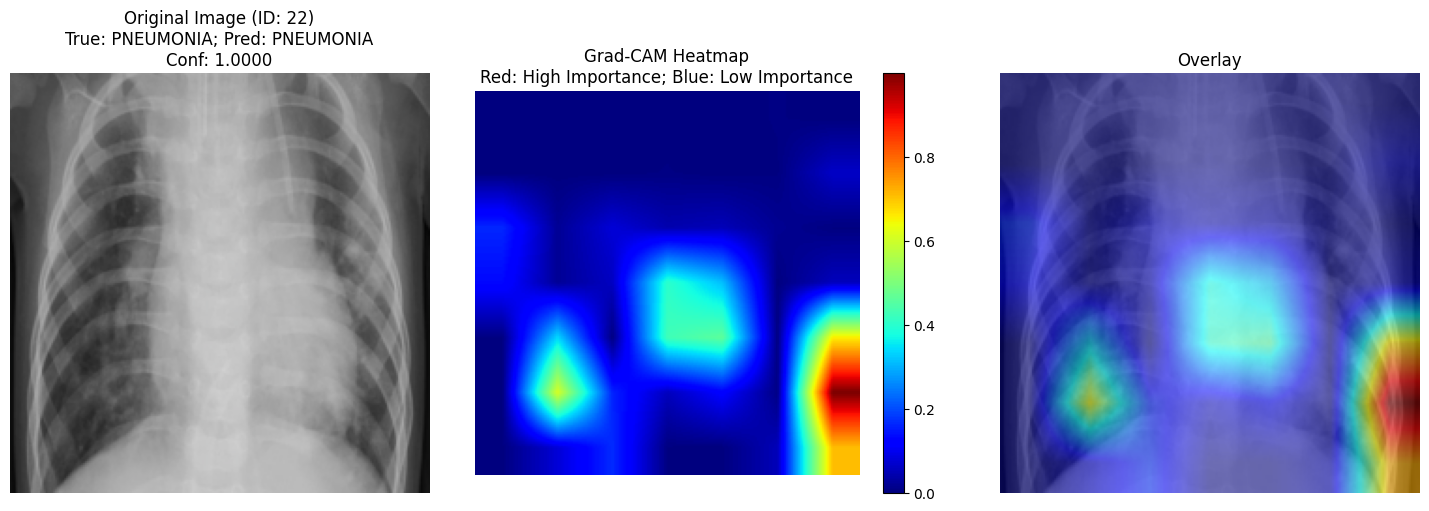

Saved figure to: d:\jherng\Workspace\university\masters\courses\year2526_sem1\wqf7009_explainable_artificial_intelligence\assignment3\wqf7009-a3\docs\figures\gradcam_pneumonia_id22.png
[2/6] Processing example 23: Label=1.0, Pred=1.0, Prob=0.9999


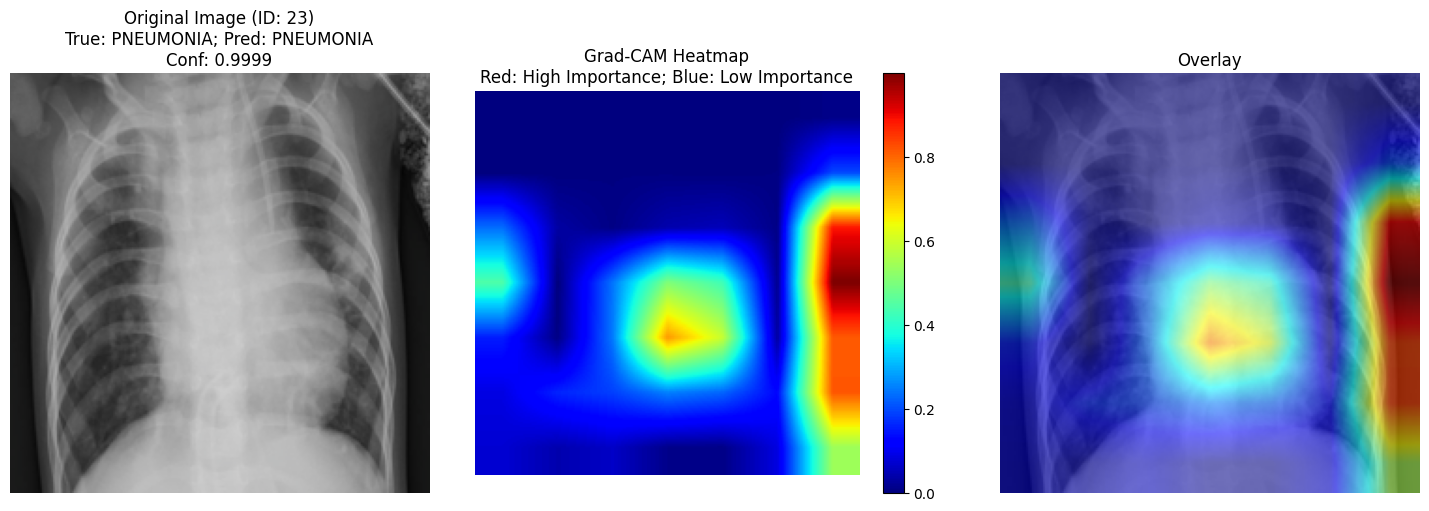

Saved figure to: d:\jherng\Workspace\university\masters\courses\year2526_sem1\wqf7009_explainable_artificial_intelligence\assignment3\wqf7009-a3\docs\figures\gradcam_pneumonia_id23.png
[3/6] Processing example 15: Label=1.0, Pred=1.0, Prob=0.9999


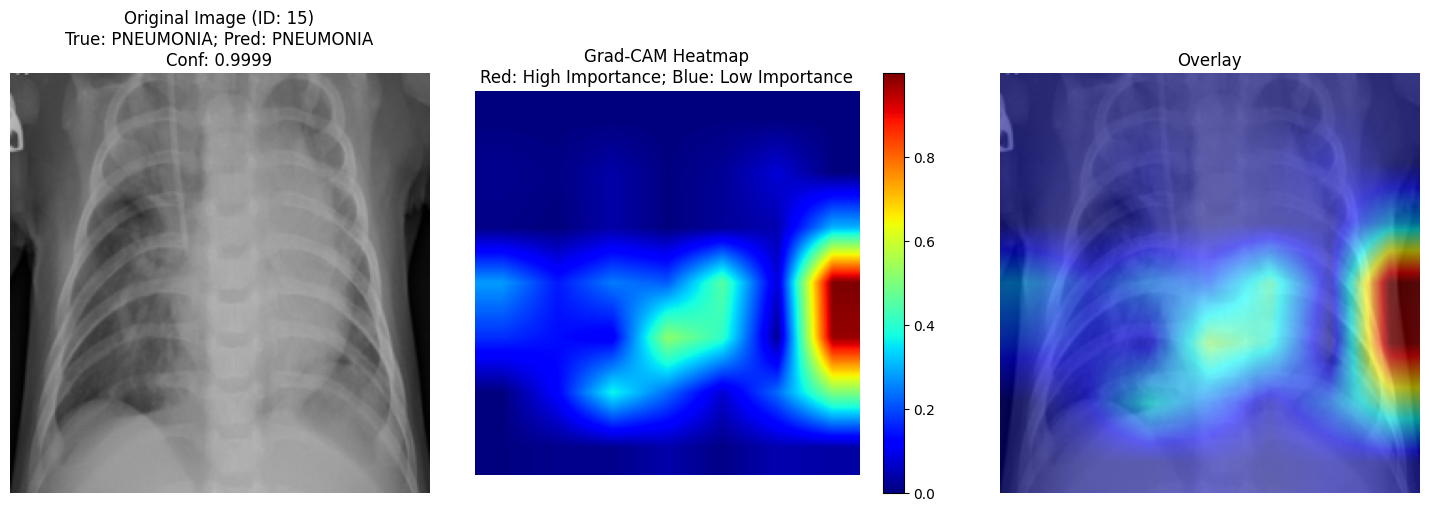

Saved figure to: d:\jherng\Workspace\university\masters\courses\year2526_sem1\wqf7009_explainable_artificial_intelligence\assignment3\wqf7009-a3\docs\figures\gradcam_pneumonia_id15.png
[4/6] Processing example 0: Label=0.0, Pred=0.0, Prob=0.0000


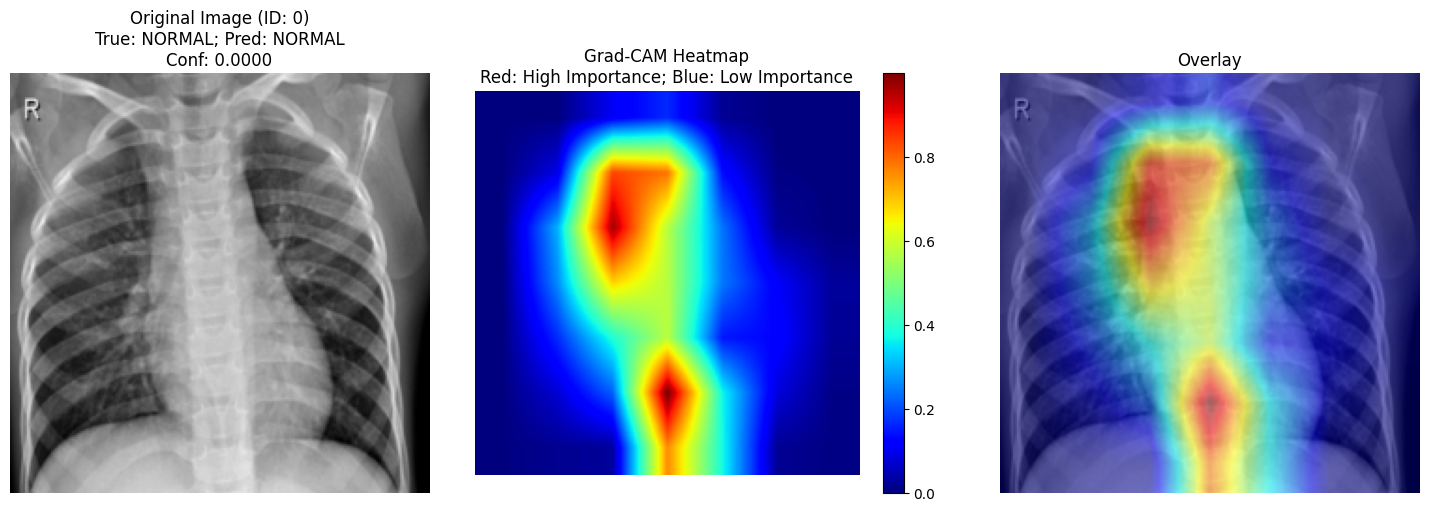

Saved figure to: d:\jherng\Workspace\university\masters\courses\year2526_sem1\wqf7009_explainable_artificial_intelligence\assignment3\wqf7009-a3\docs\figures\gradcam_normal_id0.png
[5/6] Processing example 5: Label=0.0, Pred=0.0, Prob=0.0051


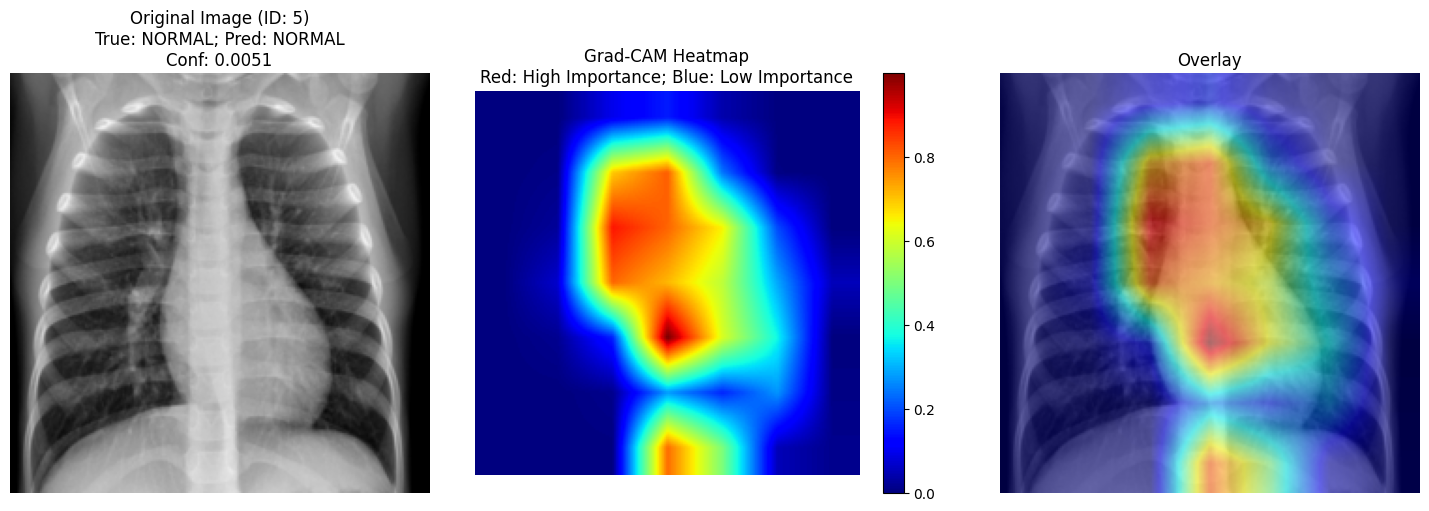

Saved figure to: d:\jherng\Workspace\university\masters\courses\year2526_sem1\wqf7009_explainable_artificial_intelligence\assignment3\wqf7009-a3\docs\figures\gradcam_normal_id5.png
[6/6] Processing example 1: Label=0.0, Pred=0.0, Prob=0.0081


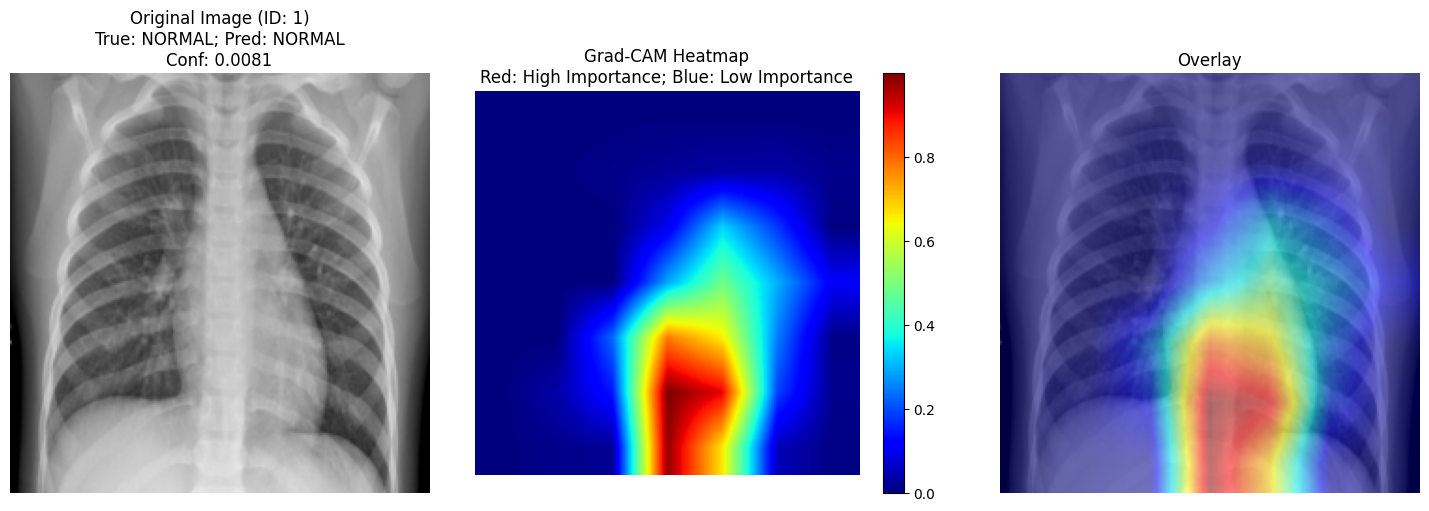

Saved figure to: d:\jherng\Workspace\university\masters\courses\year2526_sem1\wqf7009_explainable_artificial_intelligence\assignment3\wqf7009-a3\docs\figures\gradcam_normal_id1.png


In [30]:
# Generate and visualize Grad-CAM heatmaps
print(f"\nGenerating Grad-CAM visualizations for {len(all_conf_inds)} examples...")
print("-" * 70)

for i, idx in enumerate(all_conf_inds):
    row = df.loc[idx]
    print(
        f"[{i + 1}/{len(all_conf_inds)}] Processing example {idx}: "
        f"Label={row['labels']}, Pred={row['preds']}, Prob={row['probs']:.4f}"
    )

    visualize_gradcam(
        image=images[idx],
        label=labels[idx],
        output=preds[idx],
        conf=probs[idx],
        image_id=idx,
        idx_to_classname=test_loader.dataset.classes,
        gradcam=cam,
        save_path=FIG_DIR
        / f"gradcam_{test_loader.dataset.classes[labels[idx]].lower()}_id{idx}.png",
    )


### 4.2. `Task 4` - Explanation (5%)

**1. Analysis of Normal Cases (IDs 0, 1, 5)**
In the correctly classified Normal cases, the Grad-CAM heatmaps predominantly focus on the **mediastinum** (the central white region containing the heart and spine) and the clear lung fields.

- **Medical Interpretation:** This suggests the model is employing negative reasoning. By focusing on the sharp edges of the **cardiac silhouette** (the heart border), the model is confirming the **absence of the "Silhouette Sign."** In pneumonia patients, the heart border is often obscured by fluid. By verifying the heart border is crisp and defined, the model correctly deduces the lung is normal.
- **Conclusion:** The model correctly identifies "Normal" by recognizing the structural integrity of the central chest anatomy, rather than just looking at empty space.

**2. Analysis of Pneumonia Cases (IDs 15, 22, 23)**
For the Pneumonia cases, the model behavior is mixed, revealing both correct pathological detection and significant reliability issues.

- **Correct Detection:** The heatmap correctly highlights areas of the "fluffy," radiopaque (white) patches where fluid has accumulated in the lung lobes. This indicates the model has learned to identify the primary visual feature of bacterial pneumonia.
- **Shortcut Learning:** However, a concerning pattern is observed where the highest confidence regions (the "hot" red blobs) appear **outside the thoracic cage** (e.g., the background on the right side).
   - **Root Cause:** This is an example of **"Shortcut Learning"**. The model likely memorized background artifacts, such as hospital tags, cables, or specific scanner noise, that are more common in the Pneumonia dataset than in the Normal dataset.
   - **Class Imbalance:** Although we utilized a **Weighted Binary Cross Entropy Loss** (assigning a lower weight of 0.3461 to the majority Pneumonia class) to prevent the model from biased guessing, this loss function does not prevent the model from exploiting non-medical correlations in the background.


**3. Conclusion on Reliability**

While the model achieves high F1-score (0.8998), the XAI analysis tells it is **not fully reliable** for clinical deployment. It effectively detects prominent consolidation in severe cases, but its tendency to rely on background artifacts suggests that its high performance may partly stem from memorizing spurious correlations rather than understanding lung pathology. Future work may involve preprocessing to crop background artifacts to force the model to focus solely on the lung fields.


## 5. XAI Method 2 - RISE

RISE (Randomized Input Sampling for Explanation) is a model-agnostic explanation method that generates saliency maps by randomly masking input images and weighting the masks by their corresponding model predictions. Unlike Grad-CAM, RISE does not require gradient computation and can work with any black-box model.

We'll use the same batch and examples from Section 4 for consistency in comparison.

**Parameters Used for RISE:**
- **N=2000**: Number of masks (higher = better quality but slower computation)
- **s=8**: Grid size for mask generation (8x8 grid creates smoother masks)
- **p1=0.2**: Probability of masking (20% occlusion density balances between detail and coverage)

### 5.1. `Task 5` - Implementation (5%)

In [31]:
# Initialize RISE explainer and generate random masks
# Parameters:
# - N=2000: Number of random masks to generate (more masks = better quality but slower)
# - s=8: Grid size for mask generation (8x8 grid creates smoother masks)
# - p1=0.2: Probability of masking (20% occlusion density balances between detail and coverage)
explainer = RISE(
    model=resnet152_unfrozen, input_size=(IMG_SIZE, IMG_SIZE), batch_size=100
)
explainer.generate_masks(N=2000, s=8, p1=0.2)

Generating RISE masks:   0%|          | 0/20 [00:00<?, ?it/s]

Generated 2000 masks of size (224, 224)


In [32]:
# Generate RISE saliency maps for the same examples used in Grad-CAM visualization
# We'll use the examples selected in Section 4: top 3 most confident and bottom 3 least confident
print(f"\nGenerating RISE saliency maps for {len(all_conf_inds)} examples...")
print("-" * 70)

# Store saliency maps for visualization
saliency_maps = {}

for i, idx in enumerate(all_conf_inds):
    row = df.loc[idx]
    print(
        f"[{i + 1}/{len(all_conf_inds)}] Processing example {idx}: "
        f"Label={row['labels']}, Pred={row['preds']}, Prob={row['probs']:.4f}"
    )

    # Determine target class based on prediction
    target_class = int(row["labels"])

    # Generate saliency map
    saliency_map = explainer(images[idx], target_class=target_class)
    saliency_maps[idx] = saliency_map


Generating RISE saliency maps for 6 examples...
----------------------------------------------------------------------
[1/6] Processing example 22: Label=1.0, Pred=1.0, Prob=1.0000


Computing RISE saliency:   0%|          | 0/20 [00:00<?, ?it/s]

[2/6] Processing example 23: Label=1.0, Pred=1.0, Prob=0.9999


Computing RISE saliency:   0%|          | 0/20 [00:00<?, ?it/s]

[3/6] Processing example 15: Label=1.0, Pred=1.0, Prob=0.9999


Computing RISE saliency:   0%|          | 0/20 [00:00<?, ?it/s]

[4/6] Processing example 0: Label=0.0, Pred=0.0, Prob=0.0000


Computing RISE saliency:   0%|          | 0/20 [00:00<?, ?it/s]

[5/6] Processing example 5: Label=0.0, Pred=0.0, Prob=0.0051


Computing RISE saliency:   0%|          | 0/20 [00:00<?, ?it/s]

[6/6] Processing example 1: Label=0.0, Pred=0.0, Prob=0.0081


Computing RISE saliency:   0%|          | 0/20 [00:00<?, ?it/s]


Visualizing RISE saliency maps for 6 examples...
----------------------------------------------------------------------
[1/6] Visualizing example 22: Label=1.0, Pred=1.0, Prob=1.0000


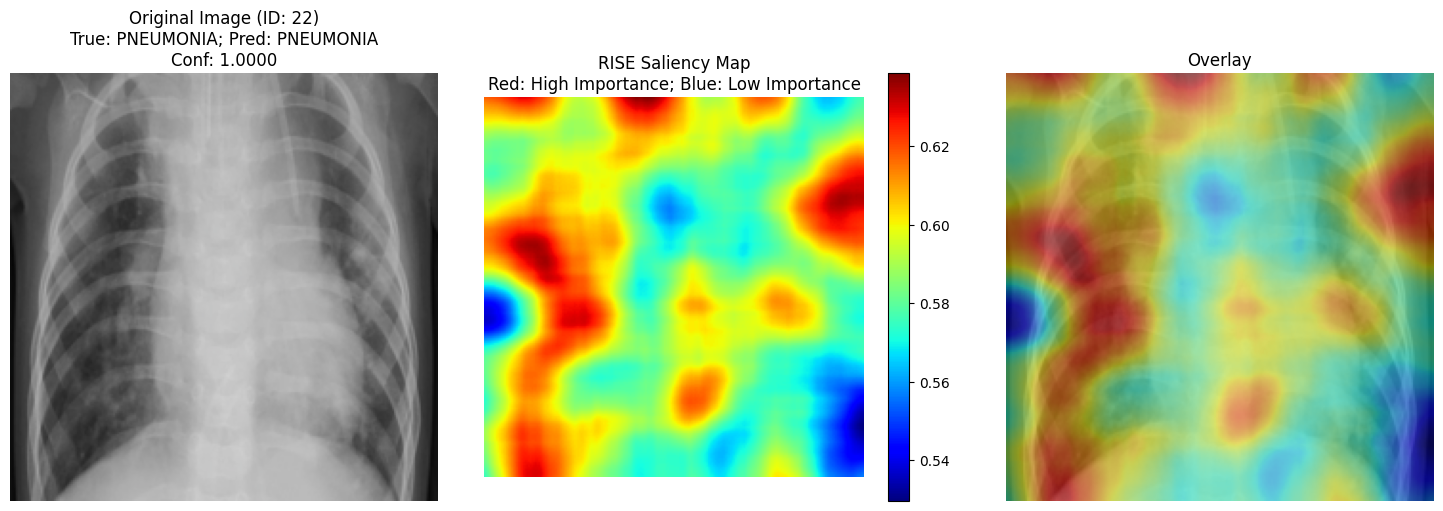

Saved figure to: d:\jherng\Workspace\university\masters\courses\year2526_sem1\wqf7009_explainable_artificial_intelligence\assignment3\wqf7009-a3\docs\figures\rise_pneumonia_id22.png
[2/6] Visualizing example 23: Label=1.0, Pred=1.0, Prob=0.9999


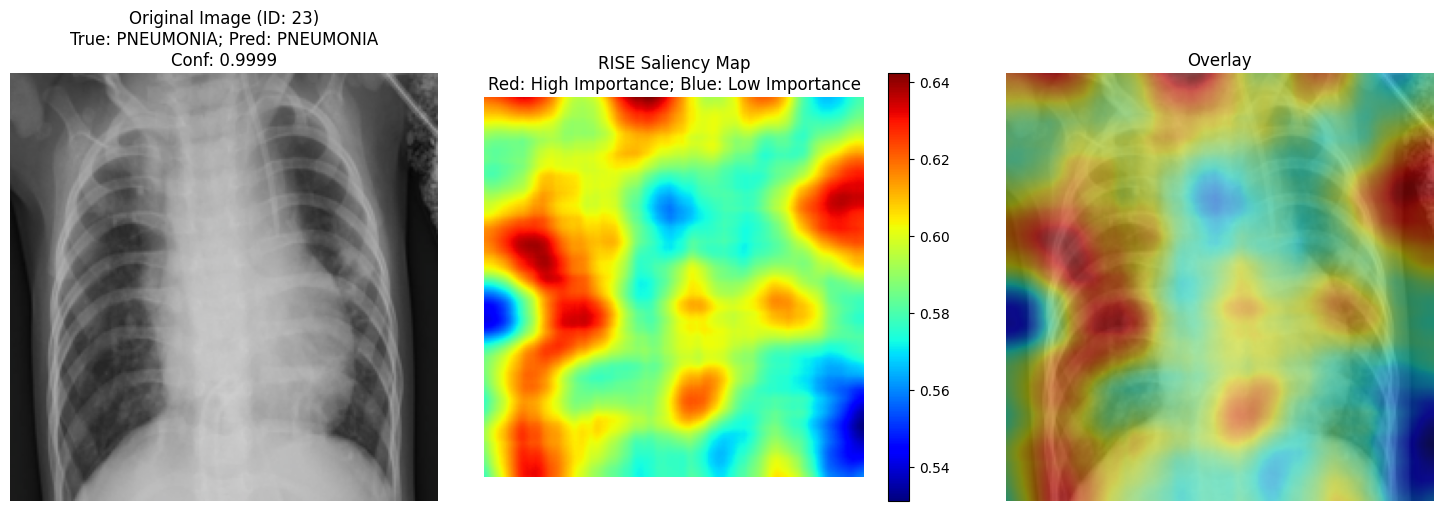

Saved figure to: d:\jherng\Workspace\university\masters\courses\year2526_sem1\wqf7009_explainable_artificial_intelligence\assignment3\wqf7009-a3\docs\figures\rise_pneumonia_id23.png
[3/6] Visualizing example 15: Label=1.0, Pred=1.0, Prob=0.9999


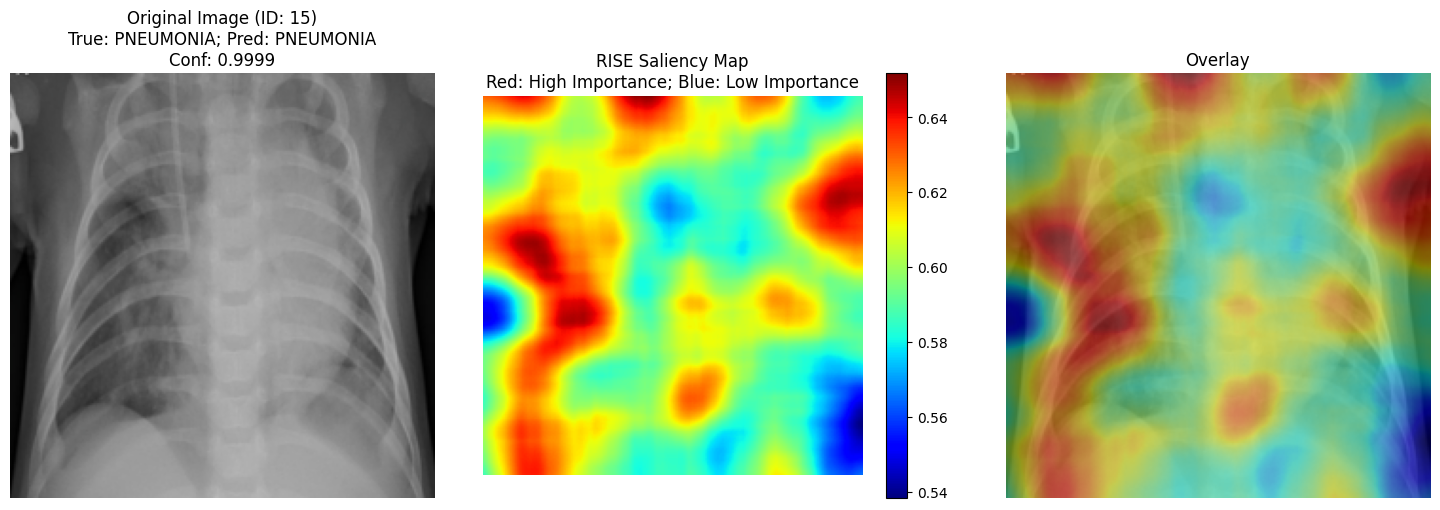

Saved figure to: d:\jherng\Workspace\university\masters\courses\year2526_sem1\wqf7009_explainable_artificial_intelligence\assignment3\wqf7009-a3\docs\figures\rise_pneumonia_id15.png
[4/6] Visualizing example 0: Label=0.0, Pred=0.0, Prob=0.0000


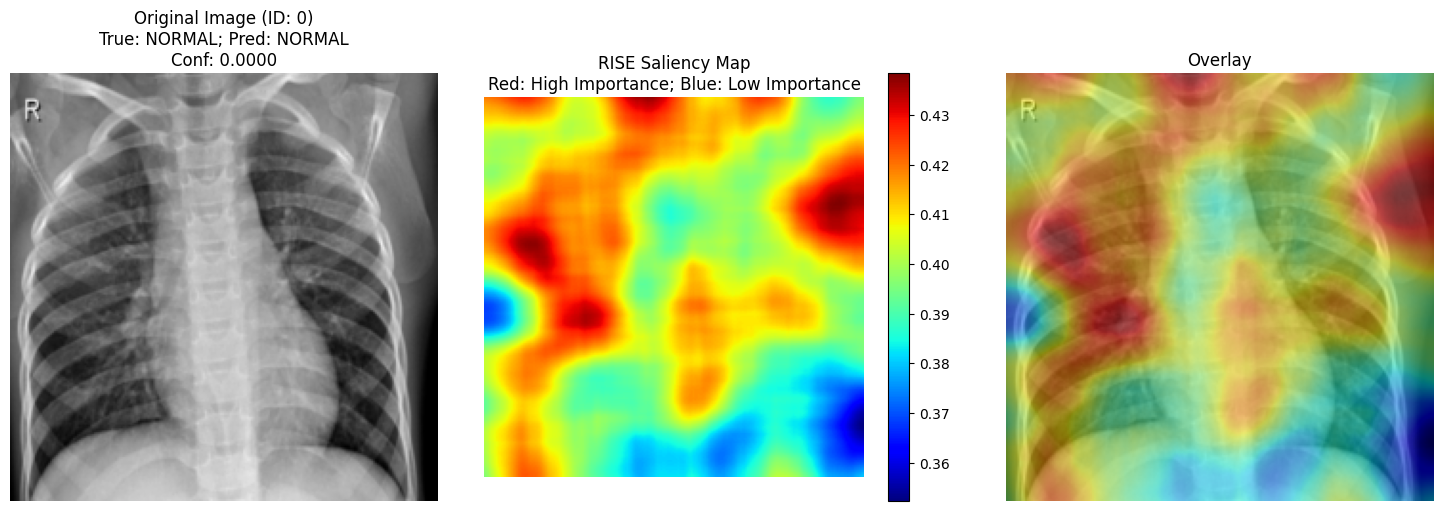

Saved figure to: d:\jherng\Workspace\university\masters\courses\year2526_sem1\wqf7009_explainable_artificial_intelligence\assignment3\wqf7009-a3\docs\figures\rise_normal_id0.png
[5/6] Visualizing example 5: Label=0.0, Pred=0.0, Prob=0.0051


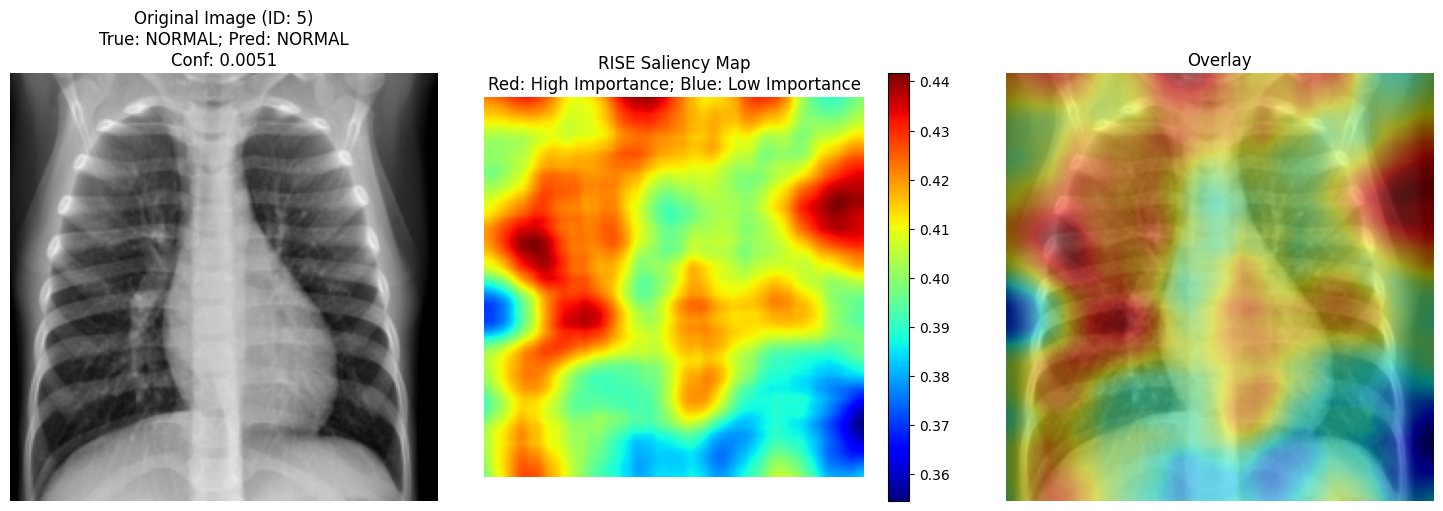

Saved figure to: d:\jherng\Workspace\university\masters\courses\year2526_sem1\wqf7009_explainable_artificial_intelligence\assignment3\wqf7009-a3\docs\figures\rise_normal_id5.png
[6/6] Visualizing example 1: Label=0.0, Pred=0.0, Prob=0.0081


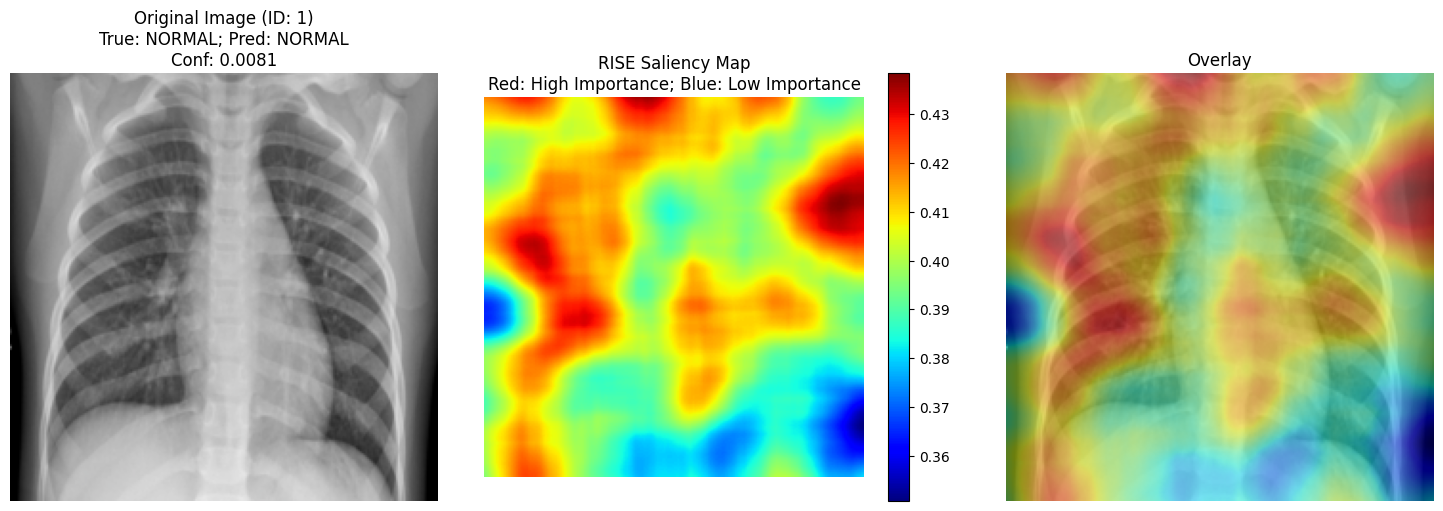

Saved figure to: d:\jherng\Workspace\university\masters\courses\year2526_sem1\wqf7009_explainable_artificial_intelligence\assignment3\wqf7009-a3\docs\figures\rise_normal_id1.png


In [33]:
# Visualize RISE saliency maps for all selected examples
print(f"\nVisualizing RISE saliency maps for {len(all_conf_inds)} examples...")
print("-" * 70)

for i, idx in enumerate(all_conf_inds):
    row = df.loc[idx]
    print(
        f"[{i + 1}/{len(all_conf_inds)}] Visualizing example {idx}: "
        f"Label={row['labels']}, Pred={row['preds']}, Prob={row['probs']:.4f}"
    )

    visualize_rise(
        image=images[idx],
        saliency_map=saliency_maps[idx],
        label=labels[idx],
        output=preds[idx],
        conf=probs[idx],
        image_id=idx,
        idx_to_classname=test_loader.dataset.classes,
        save_path=FIG_DIR
        / f"rise_{test_loader.dataset.classes[labels[idx]].lower()}_id{idx}.png",
    )

### 5.2. `Task 6` - Explanation (5%)

**1. Interpretation of RISE Heatmaps**
Unlike Grad-CAM, which uses gradients to identify discriminative regions, RISE uses randomized masking (perturbation) to test the model's sensitivity to every part of the image.

- **Normal Cases (IDs 0, 1, 5):** The RISE heatmaps display broad, continuous areas of high importance (red regions) covering the clear lung fields (right lung, left side of the image) and the **mediastinum** (heart/spine).
   - *Medical Insight:* This indicates that the model relies on the **uniformity of the texture** in healthy lungs. The continuous red signal confirms that the model is detecting the "radiolucency" (blackness of air) across the entire lung field to predict "Normal," rather than looking for a specific focal point.

- **Pneumonia Cases (IDs 15, 22, 23):** The heatmaps are more fragmented, showing scattered "blobs" of high importance focused on areas of **consolidation** (the "fluffy" white patches).
   - *Medical Insight:* This fragmentation suggests that the model is reacting to specific localized irregularities in the lung texture caused by fluid or infection, rather than a single global shape.

**2. Comparison with Grad-CAM (Task 3)**
Comparing the two methods reveals significant differences in how the model's reasoning is visualized:

- **Localization vs. Granularity:** Grad-CAM produced smooth, cohesive heatmaps because it operates on low-resolution feature maps and upsampled to the image size. In contrast, RISE produces **fine-grained, pixel-level sensitivity maps**. While Grad-CAM showed us *where* the model was looking generally, RISE reveals exactly *which pixels* caused the confidence score to drop when masked.
- **Artifacts and Noise:** RISE contains more "artifacts" (scattered red spots in the background corners). This reveals that the RISE method's fragility. Because RISE tests random occlusions, it reveals that the model is sensitive to background noise—changing pixels in the top corners (left and right) *does* affect the probability score, which Grad-CAM smoothed over.

**3. Reflection on Model Trustworthiness**
The RISE analysis reinforces the "Shortcut Learning" hypothesis raised in the Grad-CAM analysis, but makes it even more apparent.

- **Trustworthiness Issue:** The fact that RISE highlights scattered pixels outside the body (top left/right corners) confirms that the model is **over-sensitive to background noise**. While Grad-CAM showed the model *looked* at the background, RISE proves that the background *actively drives the decision*.
- **Method Evaluation:** While Grad-CAM appears "cleaner" and easier for a clinician to read rapidly, RISE provides a more honest, i.e., noisier, view of the model's pixel-level reliance. For this specific model, **Grad-CAM is the superior visualization for clinical interpretability**, as the extreme granularity of RISE makes it difficult to distinguish between true pathology detection and random model noise.
